https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4Ab47

Use of Unet for segmenting chest xray images

In [1]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

image_path = os.path.join("../input/data/Lung Segmentation/CXR_png")
mask_path = os.path.join("../input/data/Lung Segmentation/","masks/")

images = os.listdir(image_path)
masks = os.listdir(mask_path)

In [2]:
mask_f = [filename.split('.png')[0].split("_mask")[0] for filename in masks]
image_f = [filename.split('.png')[0] for filename in images]

intersection = [value for value in image_f if value in mask_f]
no_mask = [value for value in image_f if value not in mask_f]

In [3]:
print(len(mask_f), len(image_f), len(intersection), len(no_mask))

704 800 704 96


Can only generate training and validation set from 'intersection'


In [4]:
#Recover names 
data = []
for i in intersection:
    attempt1 = i+'.png'
    attempt2  = i+'_mask.png'
    if attempt1 in masks:
        data.append(attempt1)
    elif attempt2 in masks:
        data.append(attempt2)
    else:
        print("??", i)
        

In [5]:
def getData(X_shape):
    im_array = []
    mask_array = []
    
    for i in tqdm(data):
        if "_mask" in i:
            im_path = i.split("_mask")[0]+".png"
        else:
            im_path = i
        im = cv2.resize(cv2.imread(os.path.join(image_path,im_path)),
                            (X_shape,X_shape))[:, :, 0]
        mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),
                              (X_shape,X_shape))[:, :, 0]

        #im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        #mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            
        im_array.append(im)
        mask_array.append(mask)

    return im_array,mask_array

In [6]:
images, masks = getData(512)

100%|██████████| 704/704 [02:36<00:00,  4.95it/s]


In [7]:
#perform sanity check
import random

def plotMask(X,y):
    sample = []
    
    for i in random.sample(range(0, 70), 6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])                
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

# Perform Sanity Check

It is prudent to perform sanity check of the data correspondance. It become a routine check-up after a while but it is very crucial to check if we had made a mistake in loading the data.

Images with their masks - Sampled


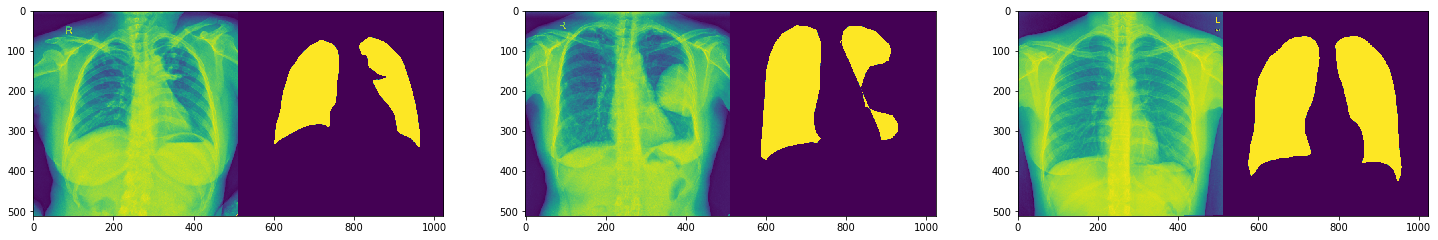

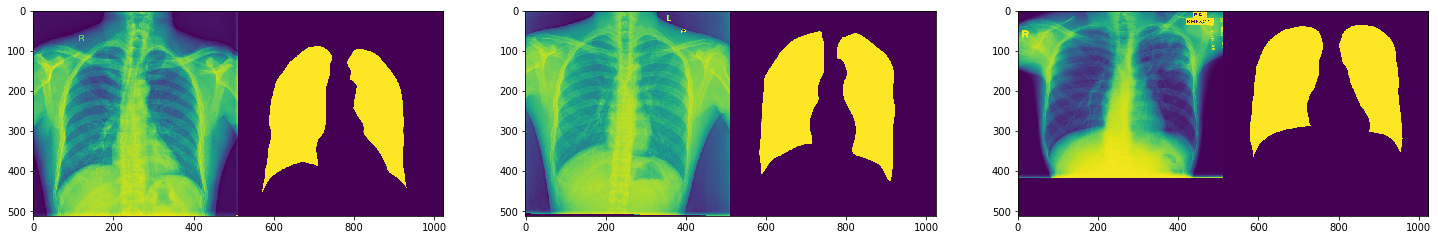

In [8]:
print("Images with their masks - Sampled")
plotMask(images,masks)

Both the sets looks correct. Let's combine them and further use them as a unified dataset.

In [9]:
dim = 512
df_images = np.array(images).reshape(len(images),dim,dim,1)
df_masks = np.array(masks).reshape(len(masks),dim,dim,1)
assert df_images.shape == df_masks.shape

In [10]:
print(df_images.shape, df_masks.shape)

(704, 512, 512, 1) (704, 512, 512, 1)


## Define  the network and callbacks

I am going to use my favourite segmentation network - U-Nets. You can read about them [here](https://arxiv.org/abs/1505.04597).

In [11]:
# From: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

Using TensorFlow backend.


In [12]:
model = unet(input_size=(512,512,1))
model.compile(optimizer=Adam(lr=2e-4), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
#model.summary()

Instructions for updating:
Colocations handled automatically by placer.


#### Compile and train the Unet Model

In [13]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-9)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


#### Train the model

In [14]:
from IPython.display import clear_output
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split



train_vol, test_vol, train_seg, test_seg = train_test_split((df_images-127.0)/127.0, 
                                                            (df_masks>127).astype(np.float32), 
                                                            test_size = 0.1,
                                                            random_state = 2019)

train_vol, validation_vol, train_seg, validation_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 2019)


In [15]:
loss_history = model.fit(x = train_vol,
                       y = train_seg,
                       batch_size = 4,
                  epochs = 150,
                  validation_data =(validation_vol, validation_seg) ,
                  callbacks=callbacks_list)


#clear_output()

Train on 569 samples, validate on 64 samples
Epoch 1/150
569/569 [==============================] - 30s 53ms/step - loss: -0.4887 - dice_coef: 0.4887 - binary_accuracy: 0.6090 - val_loss: -0.5969 - val_dice_coef: 0.5969 - val_binary_accuracy: 0.7083

Epoch 00001: val_loss improved from inf to -0.59687, saving model to cxr_reg_weights.best.hdf5
Epoch 2/150
569/569 [==============================] - 23s 41ms/step - loss: -0.7306 - dice_coef: 0.7306 - binary_accuracy: 0.8266 - val_loss: -0.8355 - val_dice_coef: 0.8355 - val_binary_accuracy: 0.9240

Epoch 00002: val_loss improved from -0.59687 to -0.83549, saving model to cxr_reg_weights.best.hdf5
Epoch 3/150
569/569 [==============================] - 23s 41ms/step - loss: -0.8874 - dice_coef: 0.8874 - binary_accuracy: 0.9430 - val_loss: -0.9120 - val_dice_coef: 0.9120 - val_binary_accuracy: 0.9542

Epoch 00003: val_loss improved from -0.83549 to -0.91196, saving model to cxr_reg_weights.best.hdf5
Epoch 4/150
569/569 [=====================

## Plot the metric and evaluate 

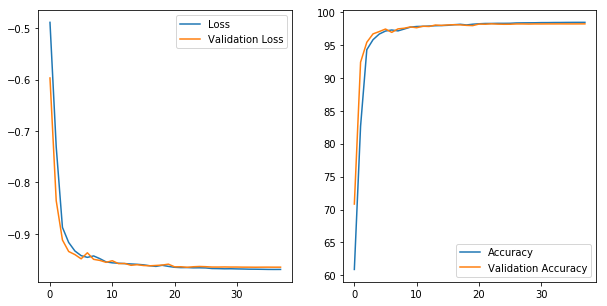

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

## Test the model

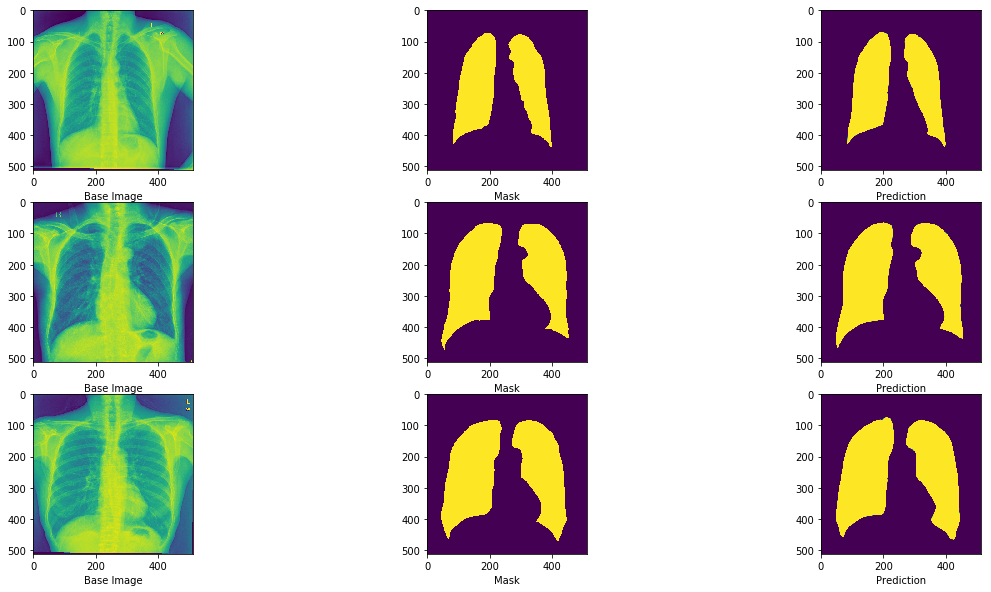

In [17]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = model.predict(validation_vol)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Prediction")

## Use model to predict for those without masks

In [18]:
im_array  = []
for i in tqdm(no_mask):        
    im = cv2.resize(cv2.imread(os.path.join(image_path,i+'.png')),
                            (512,512))[:, :, 0]                    
    im_array.append(im)

100%|██████████| 96/96 [00:09<00:00,  8.93it/s]


In [19]:
df_no_mask = np.array(im_array).reshape(len(im_array),dim,dim,1)

In [20]:
preds = model.predict((df_no_mask-127.0)/127.0)

Text(0.5, 0, 'Mask Prediction')

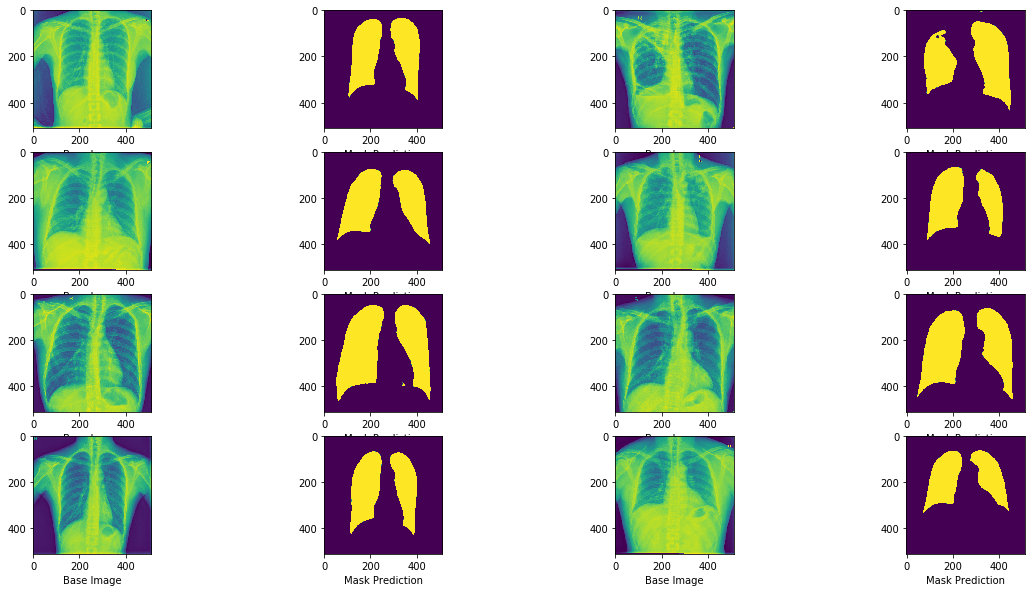

In [21]:
plt.figure(figsize=(20,10))

#random.sample(range(0, 96), 3):
i = 50
plt.subplot(4,4,1)    
plt.imshow(np.squeeze(df_no_mask[i]))
plt.xlabel("Base Image")
      
plt.subplot(4,4,2)
plt.imshow(np.squeeze(preds[i]))
plt.xlabel("Mask Prediction")

i = 70
plt.subplot(4,4,3)    
plt.imshow(np.squeeze(df_no_mask[i]))
plt.xlabel("Base Image")
      
plt.subplot(4,4,4)
plt.imshow(np.squeeze(preds[i]))
plt.xlabel("Mask Prediction")

i = 90
plt.subplot(4,4,5)    
plt.imshow(np.squeeze(df_no_mask[i]))
plt.xlabel("Base Image")
      
plt.subplot(4,4,6)
plt.imshow(np.squeeze(preds[i]))
plt.xlabel("Mask Prediction")

i = 10
plt.subplot(4,4,7)    
plt.imshow(np.squeeze(df_no_mask[i]))
plt.xlabel("Base Image")
      
plt.subplot(4,4,8)
plt.imshow(np.squeeze(preds[i]))
plt.xlabel("Mask Prediction")

i = 20
plt.subplot(4,4,9)    
plt.imshow(np.squeeze(df_no_mask[i]))
plt.xlabel("Base Image")
      
plt.subplot(4,4,10)
plt.imshow(np.squeeze(preds[i]))
plt.xlabel("Mask Prediction")

i = 30
plt.subplot(4,4,11)    
plt.imshow(np.squeeze(df_no_mask[i]))
plt.xlabel("Base Image")
      
plt.subplot(4,4,12)
plt.imshow(np.squeeze(preds[i]))
plt.xlabel("Mask Prediction")

i = 40
plt.subplot(4,4,13)    
plt.imshow(np.squeeze(df_no_mask[i]))
plt.xlabel("Base Image")
      
plt.subplot(4,4,14)
plt.imshow(np.squeeze(preds[i]))
plt.xlabel("Mask Prediction")

i = 60
plt.subplot(4,4,15)    
plt.imshow(np.squeeze(df_no_mask[i]))
plt.xlabel("Base Image")
      
plt.subplot(4,4,16)
plt.imshow(np.squeeze(preds[i]))
plt.xlabel("Mask Prediction")


Save the output masks

True

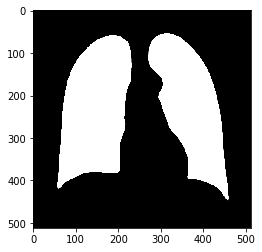

In [22]:
x = preds[1]
xx = np.tile(x, (1, 1, 3))
plt.imshow(xx)
cv2.imwrite('output_sample.png', xx)

In [23]:
'''for i in range(len(no_mask)):
    result_file = no_mask[i]
    item = np.tile(preds[i], (1, 1, 3)) #expanded to three channels
    img = item.astype(np.uint8)
    filename = os.path.basename(no_mask[i])
    fileext = '.png'
    result_file = os.path.join("%s_mask_predict%s" % (filename, fileext))
    cv2.imwrite(result_file, img)'''

'for i in range(len(no_mask)):\n    result_file = no_mask[i]\n    item = np.tile(preds[i], (1, 1, 3)) #expanded to three channels\n    img = item.astype(np.uint8)\n    filename = os.path.basename(no_mask[i])\n    fileext = \'.png\'\n    result_file = os.path.join("%s_mask_predict%s" % (filename, fileext))\n    cv2.imwrite(result_file, img)'